In [1]:
import numpy as np
a = np.array([1,2,3])
b = np.array([4,5,6])
print(a*b)
print(np.dot(a,b))

[ 4 10 18]
32


In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
import shap

/opt/homebrew/anaconda3/envs/ML/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 데이터 전처리

In [2]:
path = 'data/raw_data.csv'
dataset = pd.read_csv(path)
print('dataset 내 null 갯수 :',dataset.isnull().sum().sum())
dataset.columns

dataset 내 null 갯수 : 0


Index(['b', 'h', 'd', 'd'', 'L', 'l', 'a', 'fck', 'As', 'fy', 'As'', 'fy'',
       'material', 'C', 'PBO', 'G', 'CF', 'B', 'ff', 'Af', 'layer', 'Swr',
       'Swf', 'Anchorage', 'Py'],
      dtype='object')

In [ ]:
dataset = dataset.drop('material', axis=1)
dataset

,b,h,d,d',L,l,a,fck,As,fy,...,G,CF,B,ff,Af,layer,Swr,Swf,Anchorage,Py
0,400,250,200.00,50,2400,2200,750,40.00,461.8,523.15,...,0,0,0,0,0.00,0,0.0,0.0,0,134.80
1,400,250,200.00,50,2400,2200,750,40.00,461.8,523.15,...,0,0,0,0,0.00,0,0.0,0.0,0,140.30
2,400,250,200.00,50,2400,2200,750,40.00,461.8,523.15,...,0,0,0,3051,31.96,2,10.0,10.0,0,160.00
3,400,250,200.00,50,2400,2200,750,40.00,461.8,523.15,...,0,0,0,3051,31.96,2,10.0,10.0,0,175.00
4,150,250,209.00,41,2400,2200,850,30.00,157.1,500.00,...,0,0,0,0,0.00,0,0.0,0.0,0,39.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,120,135,118.89,0,1500,1300,450,42.19,142.6,580.00,...,0,0,0,4900,2.77,1,10.0,10.0,0,36.49
96,120,135,118.89,0,1500,1300,450,42.19,142.6,580.00,...,0,0,0,4900,2.77,1,10.0,10.0,0,34.40
97,120,135,118.89,0,1500,1300,450,42.19,142.6,580.00,...,0,0,0,4900,8.32,3,10.0,10.0,0,40.44
98,120,135,118.89,0,1500,1300,450,42.19,142.6,580.00,...,0,0,0,4900,8.32,3,10.0,10.0,0,42.66


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
label = 'Py'

def scaling(data, scaler):
    scaled = scaler.fit_transform(data)
    return scaled, scaler

# features = dataset.drop(label, axis=1)
# labels = dataset[label]

# x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size = 0.2, shuffle=True, random_state=1)

# idx = 1

# scaler_list = [MinMaxScaler(), StandardScaler(), RobustScaler()]
# scaler = scaler_list[idx]
# # x_train, x_test 스케일링
# train_scaled, scaler = scaling(x_train,scaler)
# test_scaled = scaler.transform(x_test)
# x_train = pd.DataFrame(train_scaled)
# x_test  = pd.DataFrame(test_scaled)

# # columns 이름이 다 소실되었으므로 복구
# x_train.columns = dataset.drop(label, axis=1).columns
# x_test.columns = dataset.drop(label, axis=1).columns

# # 저장
# name_list = ['minmax','standard', 'robust']
# x_train.to_csv('data/train/{}_data.csv'.format(name_list[idx]))
# y_train.to_csv('data/train/label.csv')
# x_test.to_csv('data/test/{}_data.csv'.format(name_list[idx]))
# y_test.to_csv('data/test/label.csv')


In [3]:
# 데이터 불러오기
idx = 1
name_list = ['minmax','standard', 'robust']
x_train = pd.read_csv('data/train/{}_data.csv'.format(name_list[idx]), index_col=0)
y_train = pd.read_csv('data/train/label.csv', index_col=0)
x_test = pd.read_csv('data/test/{}_data.csv'.format(name_list[idx]),index_col=0)
y_test = pd.read_csv('data/test/label.csv', index_col=0)

x_train = torch.Tensor(np.array(x_train))
y_train = torch.Tensor(np.array(y_train))
x_test = torch.Tensor(np.array(x_test))
y_test = torch.Tensor(np.array(y_test))
    

## Training

### Multi Layer Perceptron(ANN)

In [4]:
import torch
import torch.nn as nn

def weight_init_xavier_uniform(submodule):
    if isinstance(submodule, torch.nn.Conv2d):
        torch.nn.init.xavier_uniform_(submodule.weight)
        submodule.bias.data.fill_(0.01)
    elif isinstance(submodule, torch.nn.BatchNorm2d):
        submodule.weight.data.fill_(1.0)
        submodule.bias.data.zero_()

class mlp_model(nn.Module):
    def __init__(self):
        super(mlp_model, self).__init__()
        
        self.mlp = nn.Sequential(
            nn.Linear(23,1024),
            nn.ELU(),
            nn.Linear(1024,512), 
            nn.ELU(),
            nn.Linear(512,512),  
            nn.ELU(), 
            nn.Linear(512,256),
            nn.ELU(),
            nn.Linear(256,1))

    def forward(self,x):
        self.mlp.apply(weight_init_xavier_uniform)
        output = self.mlp(x)
        return output

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('DEVICE =',device,'\nTorch version =',torch.__version__)
mlp = mlp_model().to(device)
x_train_mlp = x_train.to(device)
y_train_mlp = y_train.to(device)
x_test_mlp = x_test.to(device)
y_test_mlp = y_test.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr = 0.0005)

DEVICE = cpu 
Torch version = 1.12.0


In [6]:
# loss_res = []
# best = 100000
# for step in range(600):
#     optimizer.zero_grad()
#     prediction = mlp(x_train_mlp)
#     loss = criterion(prediction.to(device), torch.Tensor(np.array(y_train_mlp.cpu())).to(device))
#     loss_res.append(int(loss))
#     loss.backward()
#     optimizer.step()
    
#     if best > loss_res[step]:
#         best = loss_res[step]
#         torch.save(mlp, 'best_model_GUI.pt')
        
#     if step % 100 == 0:
#         print('step :',step)
#         pass

# plt.title('training loss')
# plt.plot(loss_res[:]);


pred_test - y_test

# Evaluation

MAE : 3.6924
RMSE = 5.0211
R^2 : 0.9678


<Figure size 1080x360 with 0 Axes>

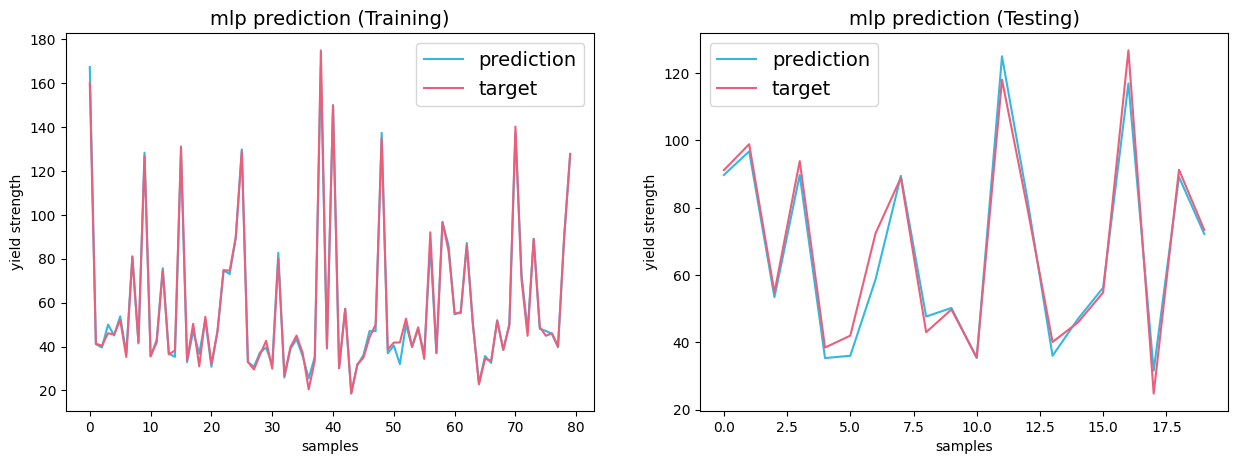

In [8]:
final_model = torch.load('pretrained_models/best_model_fixed.pt', map_location='cpu')
def to_np(tensor):
    return tensor.cpu().detach().numpy()

plt.figure(figsize=(15,5))
pred_train = final_model(x_train_mlp)
pred_test = final_model(x_test_mlp)
mae = torch.sum(torch.abs(pred_test - y_test_mlp))/len(y_test)
rmse = torch.sqrt(torch.sum(torch.square(final_model(x_test_mlp.to(device)) - y_test_mlp.to(device)))/len(y_test))
print('MAE :',format(mae,'.4f'))
print('RMSE =', format(rmse, '.4f'))
print('R^2 :', format(r2_score(to_np(pred_test), to_np(y_test_mlp)), '.4f'))

plt.figure(figsize=(15,5),dpi=100)
plt.subplot(1,2,1)
plt.title('mlp prediction (Training)', fontsize=14)
plt.xlabel('samples')
plt.ylabel('yield strength')
plt.plot(pred_train.cpu().detach().numpy(), label='prediction',color='#34b8e0')
plt.plot(y_train_mlp.cpu(), label='target',color='#eb5e7c')
plt.legend(fontsize=14)

plt.subplot(1,2,2)
plt.title('mlp prediction (Testing)', fontsize=14)
plt.xlabel('samples')
plt.ylabel('yield strength')
plt.plot(pred_test.cpu().detach().numpy(), label='prediction',color='#34b8e0')
plt.plot(y_test_mlp.cpu(), label='target',color='#eb5e7c')
plt.legend(fontsize=14)

plt.show()

In [62]:
scaler.mean_

array([1.76962500e+02, 2.42300000e+02, 2.07983500e+02, 2.58250000e+01,
       2.44106250e+03, 2.21575000e+03, 7.94250000e+02, 3.06976250e+01,
       2.30726250e+02, 4.94216000e+02, 1.10730375e+02, 3.57997250e+02,
       3.62500000e-01, 1.87500000e-01, 1.50000000e-01, 7.50000000e-02,
       3.75000000e-02, 3.12063750e+03, 1.45958750e+01, 2.12500000e+00,
       9.93250000e+00, 1.35700000e+01, 3.25000000e-01])

In [64]:
from config import feature_list, std_dict, mean_dict

for idx, feature in enumerate(feature_list):
    std_dict[feature] = scaler.scale_[idx]
    mean_dict[feature] = scaler.mean_[idx]


In [81]:

# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# print('DEVICE =',device,'\nTorch version =',torch.__version__)

# x_train = pd.read_csv('data/train/standard_data.csv', index_col=0)
# y_train = pd.read_csv('data/train/label.csv', index_col=0)
# x_test = pd.read_csv('data/test/standard_data.csv',index_col=0)
# y_test = pd.read_csv('data/test/label.csv', index_col=0)

# x_train_mlp = torch.Tensor(np.array(x_train)).to(device)
# y_train_mlp = torch.Tensor(np.array(y_train)).to(device)
# x_test_mlp = torch.Tensor(np.array(x_test)).to(device)
# y_test_mlp = torch.Tensor(np.array(y_test)).to(device)

In [11]:
from captum.attr import IntegratedGradients, DeepLift, GradientShap, NoiseTunnel, FeatureAblation, ShapleyValueSampling, LRP, KernelShap, DeepLiftShap
def to_np(tensor):
    return tensor.cpu().detach().numpy()
final_model = torch.load('pretrained_models/best_model.pt').to(device)
pred = to_np(final_model(x_test_mlp))

In [12]:
x_test_mlp[0].shape

torch.Size([23])

In [13]:
x_train = pd.read_csv('data/train/standard_data.csv', index_col=0)
y_train = pd.read_csv('data/train/label.csv', index_col=0)
x_test = pd.read_csv('data/test/standard_data.csv',index_col=0)
y_test = pd.read_csv('data/test/label.csv', index_col=0)

In [14]:
background = x_test_mlp.mean(0).unsqueeze(0)

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.


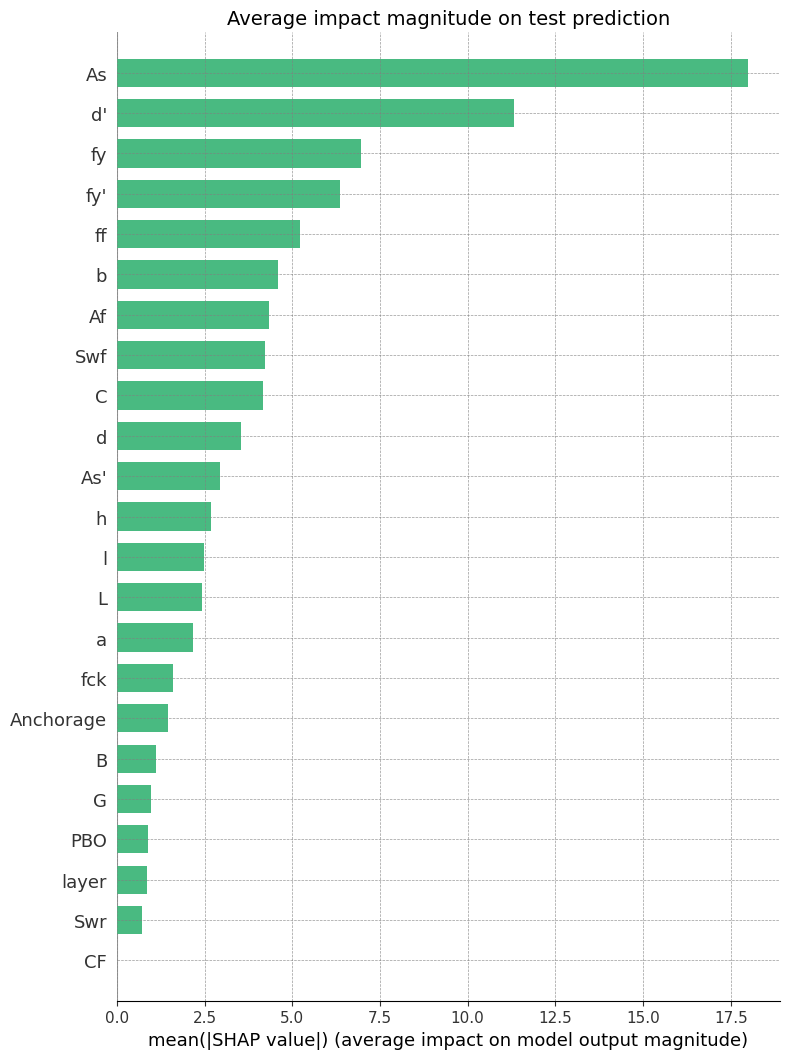

In [15]:
import matplotlib
shap.initjs()
# background = torch.tensor(x_test_mlp.mean(0))
matplotlib.style.use('default')
explainer = shap.DeepExplainer(final_model,background)
shap_values = explainer.shap_values(x_test_mlp)
plt.figure(dpi=100)
ax = plt.axes()
ax.set_facecolor("white")
plt.grid(b=True, color='grey', linestyle='--', linewidth=0.5, alpha=0.8)
plt.title('Average impact magnitude on test prediction', fontsize=14)
shap.summary_plot(shap_values, x_test, plot_type='bar',max_display=23,color='#49ba81', alpha=0.1,
                  feature_names=dataset.columns)

In [69]:
def to_np(tensor):
    return tensor.cpu().detach().numpy()

The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.


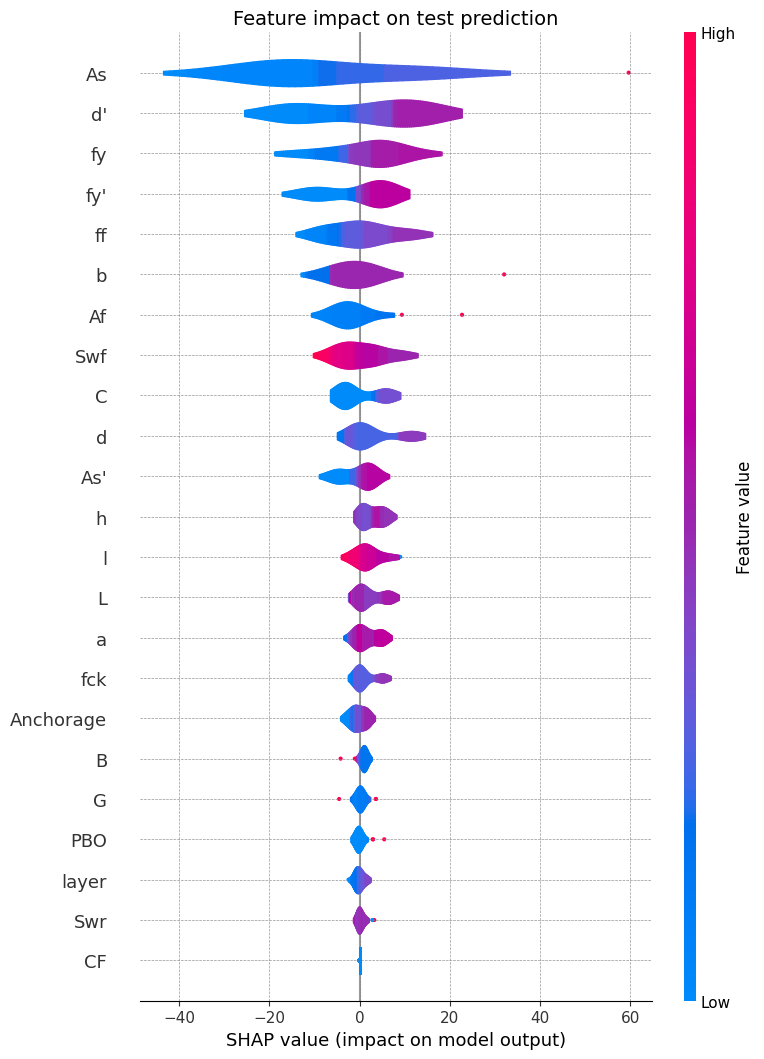

In [71]:
plt.figure(dpi=100)
plt.title('Feature impact on test prediction', fontsize=14)
plt.grid(b=True, color='grey', linestyle='--', linewidth=0.5, alpha=0.8)
shap.summary_plot(shap_values,x_test, plot_type='violin',max_display=23)

The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.


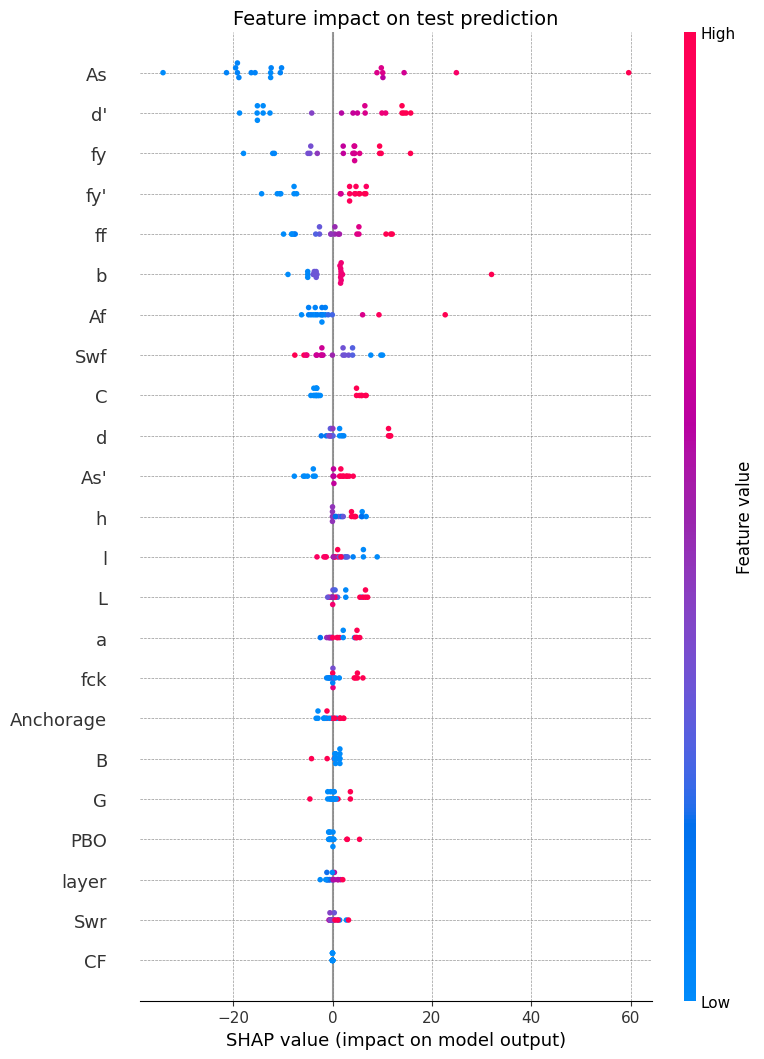

In [72]:

plt.figure(dpi=100)
plt.grid(b=True, color='grey', linestyle='--', linewidth=0.5, alpha=0.8)
plt.title('Feature impact on test prediction', fontsize=14)
shap.summary_plot(shap_values,x_test, plot_type='dot',max_display=23)